### Introduction 

QuDynamics provides a framework to solve Quantum Mechanics Equations using various solvers like : 

1. `ode45`, `ode78`, `ode23s` solvers from ODE.jl
2. `expmv` from QuExpmV.jl, QuExpokit.jl
3. Monte Carlo Wavefunction Method
4. Euler, Crank Nicholson, Krylov solver methods.

to solve Time independent and Time dependent 

1. Schrodinger Equation
2. Liouville von Neumann Equation
3. Lindblad Master Equation

----------

The package uses various basic constructs from QuBase.jl, the base package which includes all the necessary machinery for quantum physics related operations. PyPlot.jl will be used for plotting. Loading all the packages

In [2]:
using QuBase
using QuDynamics
using PyPlot


---

The following are the minimum parameters to define a system 

1. Hamiltonian of the system
2. Initial state of the system
3. Time steps at which the system is evolved

#### Defining the system

<style TYPE="text/css">
code.has-jax {font: inherit; font-size: 100%; background: inherit; border: inherit;}
</style>
<script type="text/x-mathjax-config">
MathJax.Hub.Config({
    tex2jax: {
        inlineMath: [['$','$'], ['\\(','\\)']],
        skipTags: ['script', 'noscript', 'style', 'textarea', 'pre'] // removed 'code' entry
    }
});
MathJax.Hub.Queue(function() {
    var all = MathJax.Hub.getAllJax(), i;
    for(i = 0; i < all.length; i += 1) {
        all[i].SourceElement().parentNode.className += ' has-jax';
    }
});
</script>
<script type="text/javascript" src="http://cdn.mathjax.org/mathjax/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML"></script>

Setting up a very basic system by defining the above parameters

Hamiltonian ℋ = σₓ 

Initial State ψ = $\begin{pmatrix}
  1  \\
  0
 \end{pmatrix}$

Time steps = 0. - 2*$\pi$ spaced at 0.01

##### Converting the above data into a suitable format for QuDynamics

In [20]:
ℋ = σₓ;
ψ = statevec(1, FiniteBasis(2));
tₙ = 0.:0.01:2*pi;

Using the above data along with a specific solver from 

* QuODE45
* QuODE78
* QuODE23s
* QuExpmV
* QuExpokit
* QuEuler
* QuCrankNicolson
* QuKrylov

construct `prop_expmV`. 

Note : `QuPropagator` and `QuPropagatorState` are equivalent.

In [21]:
prop_expmV = QuPropagator(ℋ, ψ, tₙ, QuExpmV())

QuDynamics.QuStateEvolution{QuDynamics.QuExpmV,QuBase.QuArray{QuBase.FiniteBasis{QuBase.Orthonormal},Float64,1,Array{Float64,1}},QuDynamics.QuSchrodingerEq{H<:QuBase.AbstractQuArray{B<:QuBase.AbstractBasis{S<:QuBase.AbstractStructure},T,2}}}(QuDynamics.QuSchrodingerEq{QuBase.QuArray{QuBase.FiniteBasis{QuBase.Orthonormal},Float64,2,Array{Float64,2}}}(2x2 QuMatrix in QuBase.FiniteBasis{QuBase.Orthonormal}:
...coefficients: Array{Float64,2}
[0.0 1.0
 1.0 0.0]),2-element QuVector in QuBase.FiniteBasis{QuBase.Orthonormal}:
...coefficients: Array{Float64,1}
[1.0,0.0],0.0:0.01:6.28,QuDynamics.QuExpmV(Dict{Symbol,Any}()))

Evolution can be done in the following way,  plotting the evolved states

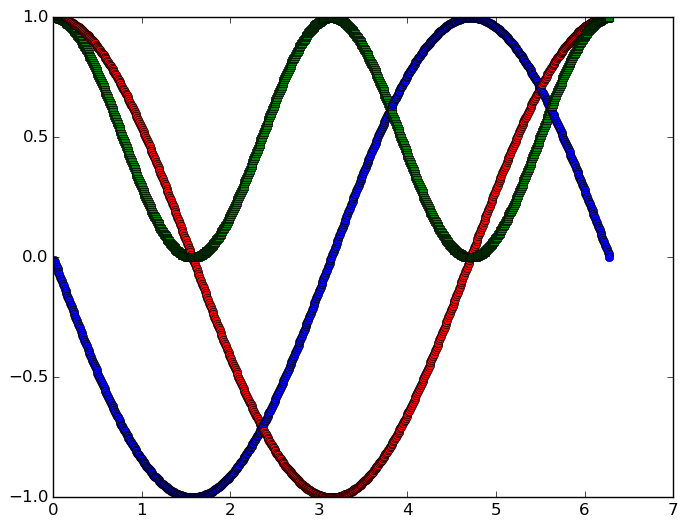

In [22]:
for (t, psi) in prop_expmV
    plot(t, real(coeffs(psi)[1]), "ro")
    plot(t, imag(coeffs(psi)[2]), "bo")
    plot(t, expectationvalue(psi, lowerop(2)*lowerop(2)'), "gs")
end

Let's try other solver and see if the result is the same 

In [23]:
prop_ode45 = QuPropagator(ℋ, ψ, tₙ, QuODE45())

QuDynamics.QuStateEvolution{QuDynamics.QuODE45,QuBase.QuArray{QuBase.FiniteBasis{QuBase.Orthonormal},Float64,1,Array{Float64,1}},QuDynamics.QuSchrodingerEq{H<:QuBase.AbstractQuArray{B<:QuBase.AbstractBasis{S<:QuBase.AbstractStructure},T,2}}}(QuDynamics.QuSchrodingerEq{QuBase.QuArray{QuBase.FiniteBasis{QuBase.Orthonormal},Float64,2,Array{Float64,2}}}(2x2 QuMatrix in QuBase.FiniteBasis{QuBase.Orthonormal}:
...coefficients: Array{Float64,2}
[0.0 1.0
 1.0 0.0]),2-element QuVector in QuBase.FiniteBasis{QuBase.Orthonormal}:
...coefficients: Array{Float64,1}
[1.0,0.0],0.0:0.01:6.28,QuDynamics.QuODE45(Dict{Symbol,Any}()))

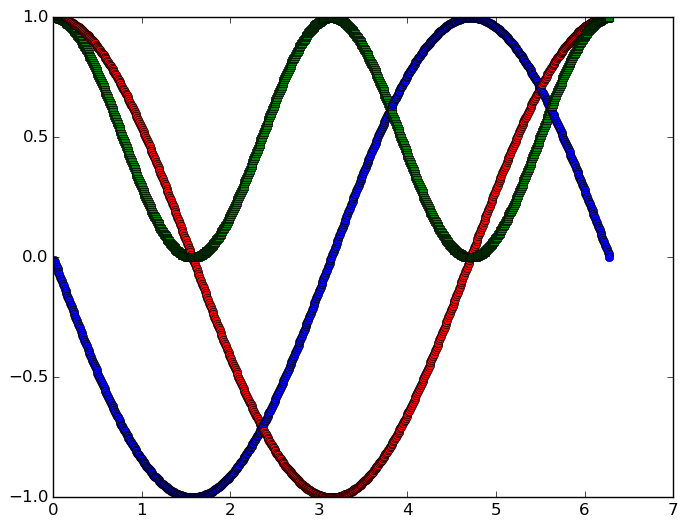

In [24]:
for (t, psi) in prop_ode45
    plot(t, real(coeffs(psi)[1]), "ro")
    plot(t, imag(coeffs(psi)[2]), "bo")
    plot(t, expectationvalue(psi, lowerop(2)*lowerop(2)'), "gs")
end

Looking at the above results, the above construction is also equivalent to

In [25]:
ℋₑ = QuSchrodingerEq(σₓ);
prop_expmv = QuPropagator(ℋₑ, ψ, tₙ, QuExpmV())

QuDynamics.QuStateEvolution{QuDynamics.QuExpmV,QuBase.QuArray{QuBase.FiniteBasis{QuBase.Orthonormal},Float64,1,Array{Float64,1}},QuDynamics.QuSchrodingerEq{H<:QuBase.AbstractQuArray{B<:QuBase.AbstractBasis{S<:QuBase.AbstractStructure},T,2}}}(QuDynamics.QuSchrodingerEq{QuBase.QuArray{QuBase.FiniteBasis{QuBase.Orthonormal},Float64,2,Array{Float64,2}}}(2x2 QuMatrix in QuBase.FiniteBasis{QuBase.Orthonormal}:
...coefficients: Array{Float64,2}
[0.0 1.0
 1.0 0.0]),2-element QuVector in QuBase.FiniteBasis{QuBase.Orthonormal}:
...coefficients: Array{Float64,1}
[1.0,0.0],0.0:0.01:6.28,QuDynamics.QuExpmV(Dict{Symbol,Any}()))

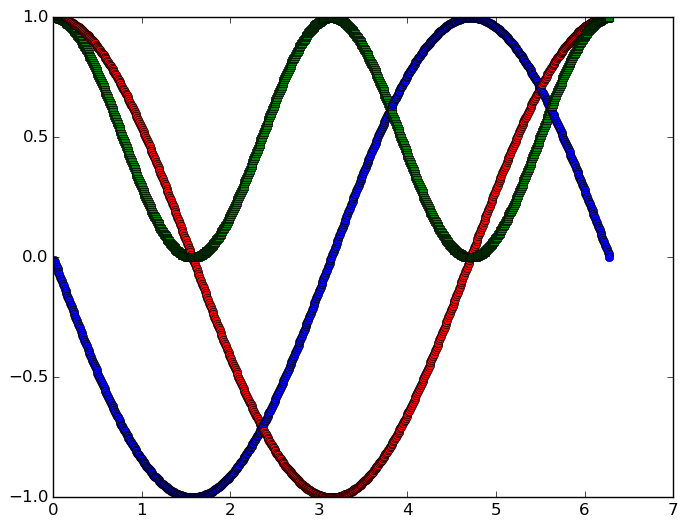

In [26]:
for (t, psi) in prop_expmv
    plot(t, real(coeffs(psi)[1]), "ro")
    plot(t, imag(coeffs(psi)[2]), "bo")
    plot(t, expectationvalue(psi, lowerop(2)*lowerop(2)'), "gs")
end

---

Using density matrix formulation for the above system results in Liouville von Neumann Equation. Using the same formulation as above :

In [27]:
qprop_lvn = QuPropagator(ℋ, ψ*ψ', tₙ, QuODE45())

QuDynamics.QuStateEvolution{QuDynamics.QuODE45,QuBase.QuArray{QuBase.FiniteBasis{QuBase.Orthonormal},Float64,2,Array{Float64,2}},QuDynamics.QuLiouvillevonNeumannEq{H<:QuBase.AbstractQuArray{B<:QuBase.AbstractBasis{S<:QuBase.AbstractStructure},T,2}}}(QuDynamics.QuLiouvillevonNeumannEq{QuBase.QuArray{QuBase.FiniteBasis{QuBase.Orthonormal},Complex{Float64},2,SparseMatrixCSC{Complex{Float64},Int64}}}(4x4 QuMatrix in QuBase.FiniteBasis{QuBase.Orthonormal}:
...coefficients: SparseMatrixCSC{Complex{Float64},Int64}

	[2, 1]  =  1.0+0.0im
	[3, 1]  =  -1.0+0.0im
	[1, 2]  =  1.0+0.0im
	[4, 2]  =  -1.0+0.0im
	[1, 3]  =  -1.0+0.0im
	[4, 3]  =  1.0+0.0im
	[2, 4]  =  -1.0+0.0im
	[3, 4]  =  1.0+0.0im),2x2 QuMatrix in QuBase.FiniteBasis{QuBase.Orthonormal}:
...coefficients: Array{Float64,2}
[1.0 0.0
 0.0 0.0],0.0:0.01:6.28,QuDynamics.QuODE45(Dict{Symbol,Any}()))

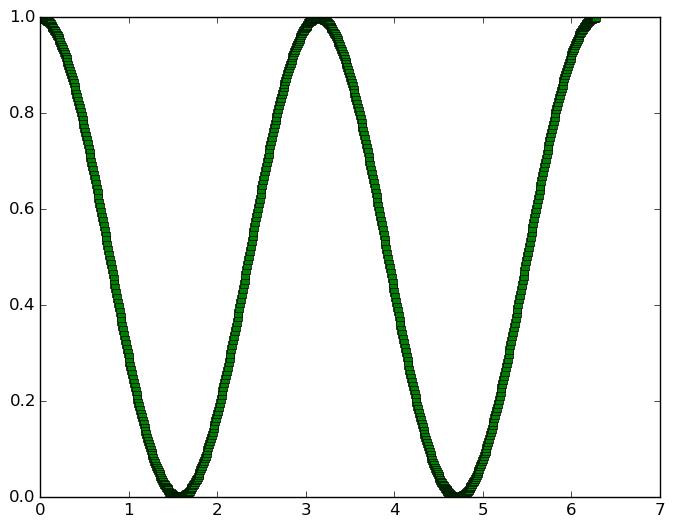

In [28]:
for (t, ψₘ) in  qprop_lvn
    plot(t, expectationvalue(ψₘ, lowerop(2)*lowerop(2)'), "gs")
end

---

A more realistic system would involve influence of the environment whose information is captured by the action of the collapse operators on the Hamiltonian. Consider the following toy model :

In [32]:
ℋₛ = σₓ;
ψ = statevec(1, FiniteBasis(2));
ρ = ψ*ψ';
tlist = 0.:0.01:2*π;
𝓒 = [lowerop(2)];

In [33]:
qme = QuPropagator(ℋₛ, 𝓒, ρ,  tlist, QuExpmV())

QuDynamics.QuStateEvolution{QuDynamics.QuExpmV,QuBase.QuArray{QuBase.FiniteBasis{QuBase.Orthonormal},Float64,2,Array{Float64,2}},QuDynamics.QuLindbladMasterEq{CF,L<:Union{QuBase.AbstractQuArray{B<:QuBase.AbstractBasis{S<:QuBase.AbstractStructure},T,2},Void},H<:QuBase.AbstractQuArray{B<:QuBase.AbstractBasis{S<:QuBase.AbstractStructure},T,2},V<:QuBase.AbstractQuArray{B<:QuBase.AbstractBasis{S<:QuBase.AbstractStructure},T,2}}}(QuDynamics.QuLindbladMasterEq{1,QuBase.QuArray{QuBase.FiniteBasis{QuBase.Orthonormal},Complex{Float64},2,SparseMatrixCSC{Complex{Float64},Int64}},QuBase.QuArray{QuBase.FiniteBasis{QuBase.Orthonormal},Float64,2,Array{Float64,2}},QuBase.QuArray{QuBase.FiniteBasis{QuBase.Orthonormal},Float64,2,SparseMatrixCSC{Float64,Int64}}}(4x4 QuMatrix in QuBase.FiniteBasis{QuBase.Orthonormal}:
...coefficients: SparseMatrixCSC{Complex{Float64},Int64}

	[2, 1]  =  1.0+0.0im
	[3, 1]  =  -1.0+0.0im
	[1, 2]  =  1.0+0.0im
	[2, 2]  =  -0.0-0.5im
	[4, 2]  =  -1.0+0.0im
	[1, 3]  =  -1.0+0.0

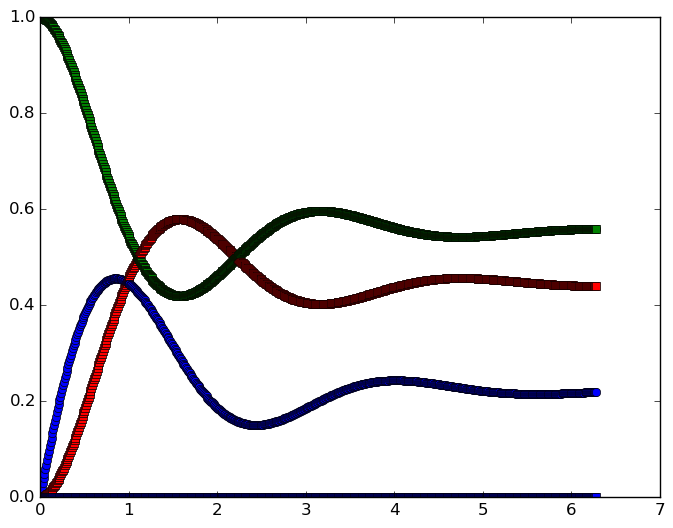

In [34]:
for (t, ρₙ) in qme
    plot(t, real(coeffs(ρₙ)[1,1]), "ro")
    plot(t, real(coeffs(ρₙ)[2,2]), "rs")
    plot(t, imag(coeffs(ρₙ)[1,2]), "bo")
    plot(t, imag(coeffs(ρₙ)[2,2]), "bs")
    plot(t, expectationvalue(ρₙ, lowerop(2)*lowerop(2)'), "gs")
end

---

##### More  realistic example - Jaynes Cummings Model

In [35]:
function jc_setup(N, wc, wa, g, kappa, gamma, use_rwa)
    # Hamiltonian
    idc = QuArray(eye(N))
    ida = QuArray(eye(2))
    a  = tensor(lowerop(N), ida)
    sm = tensor(idc, lowerop(2))
    if use_rwa
        # use the rotating wave approxiation
        H = wc * a' * a + wa * sm' * sm + g * (a' * sm + a * sm')
    else
        H = wc * a' * a + wa * sm' * sm + g * (a' + a) * (sm + sm')
    end
    # collapse operators
    c_op_list = Array(QuBase.AbstractQuMatrix, 0)
    n_th_a = 0.0
    rate = kappa * (1 + n_th_a)
    if rate > 0.0
       push!(c_op_list, full(sqrt(rate) * a))
    end
    rate = kappa * n_th_a
    if rate > 0.0
        push!(c_op_list, full(sqrt(rate) * a'))
    end
    rate = gamma
    if rate > 0.0
        push!(c_op_list, full(sqrt(rate) * sm))
    end
    return full(H), c_op_list
end

jc_setup (generic function with 1 method)

In [36]:
# parameters
wc = 1.0 * 2 * pi;   # cavity frequency
wa = 1.0 * 2 * pi;   # atom frequency
g  = 0.05 * 2 * pi;  # coupling strength
kappa = 0.05;        # cavity dissipation rate
gamma = 0.15;       # atom dissipation rate
N = 2;           # number of cavity fock states
use_rwa = true;

In [37]:
# Hamiltonian, collapse operators
H, c_ops = jc_setup(N, wc, wa, g, kappa, gamma, use_rwa);

# initial state
psi0 = complex(tensor(statevec(1, FiniteBasis(N)), statevec(2, FiniteBasis(2))));

# time steps
tlist = 0.:0.001:2*pi;

In [38]:
# setting up the system using a solver
qprop = QuPropagator(H, c_ops, psi0*psi0', tlist, QuODE45())

QuDynamics.QuStateEvolution{QuDynamics.QuODE45,QuBase.QuArray{QuBase.FiniteBasis{QuBase.Orthonormal},Complex{Float64},2,Array{Complex{Float64},2}},QuDynamics.QuLindbladMasterEq{CF,L<:Union{QuBase.AbstractQuArray{B<:QuBase.AbstractBasis{S<:QuBase.AbstractStructure},T,2},Void},H<:QuBase.AbstractQuArray{B<:QuBase.AbstractBasis{S<:QuBase.AbstractStructure},T,2},V<:QuBase.AbstractQuArray{B<:QuBase.AbstractBasis{S<:QuBase.AbstractStructure},T,2}}}(QuDynamics.QuLindbladMasterEq{1,QuBase.QuArray{QuBase.FiniteBasis{QuBase.Orthonormal},Complex{Float64},2,SparseMatrixCSC{Complex{Float64},Int64}},QuBase.QuArray{QuBase.FiniteBasis{QuBase.Orthonormal},Float64,2,Array{Float64,2}},QuBase.AbstractQuArray{B<:QuBase.AbstractBasis{S<:QuBase.AbstractStructure},T,2}}(16x16 QuMatrix in QuBase.FiniteBasis{QuBase.Orthonormal}:
...coefficients: SparseMatrixCSC{Complex{Float64},Int64}

	[2 ,  2]  =  6.28319-0.075im
	[3 ,  2]  =  0.314159+0.0im
	[2 ,  3]  =  0.314159+0.0im
	[3 ,  3]  =  6.28319-0.025im
	[4 ,  4] 

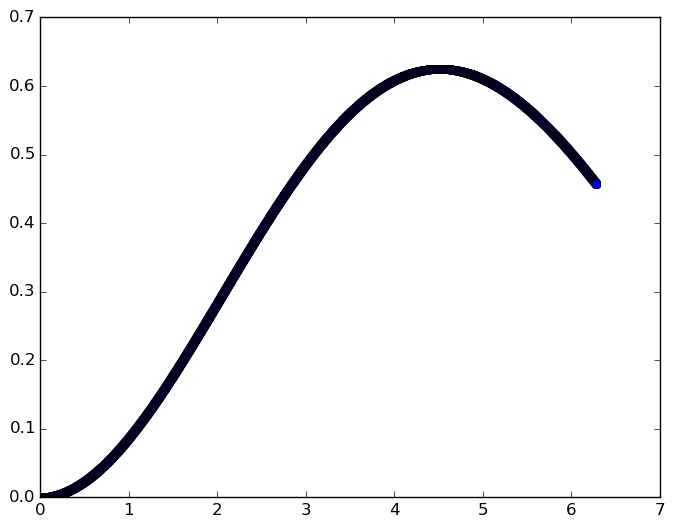

In [39]:
# Calculating the expectation values for observable a'*a
a = tensor(lowerop(2), QuArray(eye(2)))
op = a'*a
for (t, ρₘ) in  qprop
    plot(t, expectationvalue(ρₘ, op), "bo")
end

Things to include 

1. mcsolve
2. qutip interface
3. time dependent equations